In [1]:
import Bio
from Bio import AlignIO
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import pairwise2
from Bio.Alphabet import IUPAC
from Bio.pairwise2 import format_alignment
from Bio.Align.Applications import ClustalwCommandline
from Bio.SeqRecord import SeqRecord
from pydna.genbank import Genbank
from Bio import Entrez
from itertools import product

import os 
import re
import glob
import sys
import scipy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import numpy as np 
import pandas as pd
import bz2
import csv
import subprocess
import time
import seaborn as sns
import pydna

In [2]:
# get aav2 genome sequence (genbank) from NCBI and write to text file
record = open('aav2.gb', 'w')
Entrez.email = 'ninajain@g.harvard.edu'
handle = Entrez.efetch(db='nucleotide', id='NC_001401.2', rettype='gb', retmode='text')
aav2_genome = handle.read()
# print (aav2_genome)
record.write(aav2_genome.rstrip('\n'))
record.close()

with open("aav2.gb") as handle:
     aav2_gb = SeqIO.read(handle, "gb")
        
aav2_gb

SeqRecord(seq=Seq('TTGGCCACTCCCTCTCTGCGCGCTCGCTCGCTCACTGAGGCCGGGCGACCAAAG...CAA', IUPACAmbiguousDNA()), id='NC_001401.2', name='NC_001401', description='Adeno-associated virus - 2, complete genome', dbxrefs=['BioProject:PRJNA485481'])

In [3]:
# extract the region of the aav2 genome from the rep68/78 start codon to the VP stop codon
aav2_recode_region = aav2_gb[320:4410]

In [4]:
ligation_counts = pd.read_csv('../mounted_drive1/orthogonal_overhangs/FileS04_T4_18h_37C.csv', index_col=0)
ligation_counts.drop(ligation_counts.tail(1).index,inplace=True)

# Calculate score for each overhang, score = (# on-target ligations - # off-target ligations) / (total # ligations)
total_ligations = ligation_counts.values.sum()
# print (total_ligations)
scores = []
row = 0
while row < 256:
#     if row > 100: break
    on_target_ligations = 0
    off_target_ligations = 0
    count = 0
    while count < 256:
#         if count > 10: break
        if Seq(ligation_counts.columns[count]).reverse_complement() == ligation_counts.index[row]:
            on_target_ligations += ligation_counts.iloc[row, count]
        else:
            off_target_ligations += ligation_counts.iloc[row, count]
        count += 1
#     print (on_target_ligations, off_target_ligations)
    score = ((on_target_ligations - off_target_ligations) / float(total_ligations)) * 1000
    scores.append(score)
    row += 1
# print (scores)

# add scores as new column to ligation_counts
# print (len(scores))
ligation_counts = ligation_counts.assign(score = scores)
ligation_counts.head()

775566.0


,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT,score
Overhang,,,,,,,,,,,,,,,,,,,,,
TTTT,830,1.0,6.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.025058
GTTT,0,3690.0,3.0,76.0,0.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.280745
CTTT,0,1.0,3161.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.686340
ATTT,1,0.0,0.0,2634.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.294368
TGTT,1,0.0,0.0,0.0,2751.0,2.0,158.0,27.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.213137


(array([  8.,   2.,   7.,  17.,   8.,  30.,  45.,  64.,  56.,  19.]),
 array([ 0.01289381,  0.49383289,  0.97477197,  1.45571105,  1.93665014,
         2.41758922,  2.8985283 ,  3.37946738,  3.86040646,  4.34134555,
         4.82228463]),
 <a list of 10 Patch objects>)

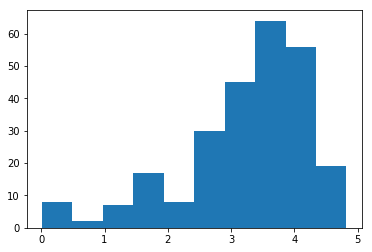

In [5]:
plt.hist(scores)

In [6]:
# Generate a data frame containing all possible overhangs (8 overhangs per junction)
possible_overhangs = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [],
                     7: [], 8: [], 9: [], 10: [], 11: [], 12: [],
                     13: [], 14: [], 15: [], 16: [], 17: []}
tile_size = 240
pos = 239
while pos < len(aav2_recode_region):
#     print (aav2_recode_region[pos])
    oh_start = pos - 4
    while oh_start < pos + 4:
        possible_overhangs[int((pos + 1)/240)].append(str(aav2_recode_region.seq)[oh_start: oh_start + 4])
        oh_start += 1
    pos += tile_size

possible_overhangs_df = pd.DataFrame.from_dict(possible_overhangs)
possible_overhangs_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,TTGT,CCAA,AGAA,GGGC,TGCG,AGGT,TCTG,GAGG,AAGT,AATT,TACA,ATTG,AGCT,TCTG,GCTA,CCGG,ACTC
1,TGTG,CAAA,GAAG,GGCC,GCGC,GGTG,CTGC,AGGA,AGTA,ATTT,ACAA,TTGC,GCTA,CTGC,CTAC,CGGT,CTCG
2,GTGC,AAAA,AAGC,GCCA,CGCG,GTGG,TGCT,GGAC,GTAC,TTTT,CAAC,TGCC,CTAC,TGCG,TACG,GGTA,TCGT
3,TGCA,AAAC,AGCA,CCAC,GCGT,TGGA,GCTT,GACA,TACA,TTTG,AACA,GCCA,TACA,GCGG,ACGG,GTAC,CGTA
4,GCAA,AACC,GCAG,CACG,CGTG,GGAG,CTTC,ACAC,ACAA,TTGG,ACAA,CCAA,ACAC,CGGA,CGGA,TACC,GTAA
5,CAAT,ACCC,CAGT,ACGA,GTGG,GAGC,TTCA,CACT,CAAC,TGGT,CAAC,CAAT,CACT,GGAT,GGAG,ACCT,TAAT
6,AATT,CCCA,AGTG,CGAA,TGGA,AGCA,TCAC,ACTC,AACC,GGTC,AACC,AATA,ACTT,GATA,GAGC,CCTG,AATC
7,ATTT,CCAG,GTGG,GAAA,GGAC,GCAT,CACT,CTCT,ACCA,GTCA,ACCA,ATAA,CTTT,ATAA,AGCA,CTGC,ATCT


In [7]:
# Remove possible overhangs from df if their score is 3.75 or less
possible_overhangs_scores_dict = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [],
                                  7: [], 8: [], 9: [], 10: [], 11: [], 12: [],
                                  13: [], 14: [], 15: [], 16: [], 17: []}

possible_overhangs_trimmed_dict = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [],
                                   7: [], 8: [], 9: [], 10: [], 11: [], 12: [],
                                   13: [], 14: [], 15: [], 16: [], 17: []}
r = 0
while r < 8:
    junction = 0
    while junction < 17:
        oh = possible_overhangs_df.iloc[r,junction]
#         print (junction)
#         print (oh)
#         print (ligation_counts.loc[oh, 'score'])
        oh_score = ligation_counts.loc[oh, 'score']
        possible_overhangs_scores_dict[junction + 1].append(oh_score)
        if oh_score > 3.75:
            possible_overhangs_trimmed_dict[junction + 1].append(oh)
        junction += 1
    r += 1

possible_overhangs_scores_df = pd.DataFrame.from_dict(possible_overhangs_scores_dict)
# print (possible_overhangs_scores_df)
print (possible_overhangs_trimmed_dict)

{1: ['CAAT'], 2: ['AAAC', 'AACC', 'ACCC', 'CCAG'], 3: ['GAAG', 'AAGC', 'AGCA'], 4: ['GCCA', 'CACG', 'CGAA'], 5: ['CGTG'], 6: ['AGGT', 'GAGC', 'AGCA', 'GCAT'], 7: ['GCTT', 'TCAC'], 8: ['GACA', 'ACAC', 'ACTC'], 9: ['GTAC', 'CAAC', 'AACC', 'ACCA'], 10: ['GGTC', 'GTCA'], 11: ['CAAC', 'CAAC', 'AACC', 'ACCA'], 12: ['ATTG', 'GCCA', 'CAAT'], 13: ['AGCT', 'ACAC'], 14: ['CGGA'], 15: ['CGGA', 'GAGC', 'AGCA'], 16: ['CCGG', 'CGGT', 'GGTA', 'GTAC', 'ACCT', 'CCTG'], 17: ['ACTC', 'CTCG', 'CGTA', 'ATCT']}


In [8]:
# Create a list of all possible overhang combinations (one per junction)

start_time = time.time()

overhang_combos_list = list(product(possible_overhangs_trimmed_dict[1], possible_overhangs_trimmed_dict[2],
                                    possible_overhangs_trimmed_dict[3], possible_overhangs_trimmed_dict[4],
                                    possible_overhangs_trimmed_dict[5], possible_overhangs_trimmed_dict[6],
                                    possible_overhangs_trimmed_dict[7], possible_overhangs_trimmed_dict[8],
                                    possible_overhangs_trimmed_dict[9], possible_overhangs_trimmed_dict[10],
                                    possible_overhangs_trimmed_dict[11], possible_overhangs_trimmed_dict[12],
                                    possible_overhangs_trimmed_dict[13], possible_overhangs_trimmed_dict[14],
                                    possible_overhangs_trimmed_dict[15], possible_overhangs_trimmed_dict[16],
                                    possible_overhangs_trimmed_dict[17]))

run_time = time.time() - start_time
print (run_time)
print (len(overhang_combos_list))

2.849114418029785
11943936


In [9]:
# Create a new list that contains only overhang combos where all overhangs are unique
overhang_combos_unique_list = []
for combo in overhang_combos_list:
    if len(combo) == len(set(combo)):
        overhang_combos_unique_list.append(combo)

print (len(overhang_combos_unique_list))
overhang_combos_unique_list[0:1]

1194480


[('CAAT',
  'AAAC',
  'GAAG',
  'GCCA',
  'CGTG',
  'AGGT',
  'GCTT',
  'GACA',
  'GTAC',
  'GGTC',
  'CAAC',
  'ATTG',
  'AGCT',
  'CGGA',
  'GAGC',
  'CCGG',
  'ACTC')]

In [10]:
# Given a potential combination of overhangs, subset ligation_counts (dataframe) so it only contains the data for those overhangs
# and calculate a score for the combination

def combo_score(overhang_combo):
#     print (type (overhang_combo))
    # Generate list of the reverse complements of all overhangs in overhang_combo
    overhang_combo_rc = []
    for ohg in list(overhang_combo):
        overhang_combo_rc.append(str((Seq(ohg).reverse_complement())))
#     print (overhang_combo_rc)
        
    # Generate a data frame containing only the ligation counts for the overhangs in this combo
    combo_ligation_counts = ligation_counts.loc[list(overhang_combo), overhang_combo_rc]
#     combo_ligation_counts = ligation_counts.loc[overhang_combo_rc, list(overhang_combo)]
#     print (combo_ligation_counts)

    # Calculate a score for this combination of overhangs
    cscore = 1
    rw = 0
    while rw < len(list(overhang_combo)):
    #     if row > 1: break
        on_target_ligs = 0
        off_target_ligs = 0
        total_ligs = combo_ligation_counts.iloc[rw, :].values.sum()
#         print (total_ligs)
        cnt = 0
        while cnt < len(overhang_combo_rc):
    #         if cnt > 1: break
            if Seq(combo_ligation_counts.columns[cnt]).reverse_complement() == combo_ligation_counts.index[rw]:
                on_target_ligs += combo_ligation_counts.iloc[rw, cnt]
            else:
                off_target_ligs += combo_ligation_counts.iloc[rw, cnt]
            cnt += 1
        cscore = cscore * float((on_target_ligs - off_target_ligs) / total_ligs)
        rw += 1
#     print (on_target_ligs, off_target_ligs)
#     print (cscore)
    return (cscore)

In [14]:
# Check scores for recommended overhang sets published in Potapov et al.
potapov_15_cycled_oh = ['TGCC', 'GCAA', 'ACTA', 'TTAC', 'CAGA', 'TGTG', 'GAGC', 'AGGA', 'ATTC', 'CGAA',
                'ATAG', 'AAGG', 'AACT', 'AAAA', 'ACCG']
potapov_20_cycled_oh = ['AGTG', 'CAGG', 'ACTC', 'AAAA', 'AGAC', 'CGAA', 'ATAG', 'AACC', 'TACA', 'TAGA',
                'ATGC', 'GATA', 'CTCC', 'GTAA', 'CTGA', 'ACAA', 'AGGA', 'ATTA', 'ACCG', 'GCGA']
potapov_25_18hr_37c_oh = ['GCCC', 'CCAA', 'ATCC', 'GGTA', 'ACGG', 'AAAT', 'ATAG', 'CTTA', 'AGGA', 'AGTC',
                'ACAC', 'ATGA', 'GCGA', 'CATA', 'CTGC', 'AACG', 'CGCC', 'AGTC', 'CCTC', 'GAAA',
                'CAGA', 'ACCA', 'AAGT', 'CGAA', 'CAAC']

potapov_10_18hr_37c_oh = ['CTTA', 'CTCC', 'ACTA', 'GGTA', 'TCCA', 'CGAA', 'AATG', 'AGCG', 'ATGG', 'AGAT']
potapov_15_18hr_37c_oh = ['AGAG', 'ACAT', 'GACA', 'AGCA', 'AATC', 'GGTA', 'CAAA', 'CCAA', 'AACG', 'CTGA',
                          'CCTC', 'ACGG', 'TCCA', 'CAGC', 'ACTA']
potapov_20_18hr_37c_oh = ['GACA', 'ACTA', 'CGGA', 'ATTA', 'AGAG', 'AACG', 'CCAA', 'GGTA', 'CTGA', 'AGGA',
                          'CAGC', 'ACGG', 'CAAA', 'GAAC', 'AGAT', 'CCTC', 'CTAC', 'AGCA', 'AATC', 'ATGA']
potapov_25b_18hr_37c_oh = ['AGCA', 'GACA', 'GTAA', 'CAGC', 'AATC', 'ATAG', 'GAAC', 'ATGA', 'AACT', 'CAAA',
                          'CTTC', 'CGTA', 'ATTA', 'CTGA', 'TCCA', 'ACTC', 'AATG', 'GCGA', 'ACAA', 'AGGG',
                          'CTCA', 'ACCG', 'CCAA', 'GGTA', 'AGAT']
potapov_30_18hr_37c_oh = ['GTAA', 'AAGT', 'ATAG', 'GAAA', 'CCAG', 'AATC', 'ATGA', 'GCAC', 'GGTA', 'CGTC',
                          'ACCG', 'ACAA', 'GCCA', 'AGGG', 'AATG', 'CAAC', 'AACT', 'CACA', 'AGCA', 'ATTA',
                          'CGAA', 'GAGA', 'CTTA', 'CCGA', 'ACGC', 'AGAT', 'CTCC', 'CAGA', 'CCTA', 'TCCA']
potapov_35_18hr_37c_oh = ['TCCA', 'AACT', 'CGTA', 'GTAA', 'AAGC', 'CCGA', 'GGGA', 'GCAA', 'ATAG', 'ATCC',
                          'AAGA', 'CCAG', 'ATGA', 'AATC', 'AGAA', 'ACAT', 'CAGA', 'CTCA', 'CCTA', 'ACGA',
                          'GACA', 'ATTA', 'AGAC', 'CAAA', 'GGTA', 'CGAA', 'CCAC', 'GAAC', 'AGGG', 'AATG',
                          'ACTA', 'CTTC', 'ACCG', 'ACTC', 'AGCA']
potapov_lacz_oh = ['GGAC', 'GATA', 'GGCA', 'GGTC', 'TCGC', 'GAGG', 'CAGT', 'GTAA', 'TCCA', 'CACA', 'GAAT',
                  'ATAG', 'AGTA', 'ATCA', 'TCTT', 'AGGT', 'CAAA', 'AAGC', 'GCAA', 'CAAC', 'AACG', 'CGAA',
                  'GTCT', 'TCAG', 'CCAT']

print ('potapov_15_cycled_oh:', combo_score(potapov_15_cycled_oh))
print ('potapov_20_cycled_oh:', combo_score(potapov_20_cycled_oh))
print ('potapov_25_18hr_37c_oh:', combo_score(potapov_25_18hr_37c_oh))
print ('potapov_10_18hr_37c_oh:', combo_score(potapov_10_18hr_37c_oh))
print ('potapov_15_18hr_37c_oh:', combo_score(potapov_15_18hr_37c_oh))
print ('potapov_20_18hr_37c_oh:', combo_score(potapov_20_18hr_37c_oh))
print ('potapov_25b_18hr_37c_oh:', combo_score(potapov_25b_18hr_37c_oh))
print ('potapov_30_18hr_37c_oh:', combo_score(potapov_30_18hr_37c_oh))
print ('potapov_35_18hr_37c_oh:', combo_score(potapov_35_18hr_37c_oh))
print ('potapov_lacz_oh:', combo_score(potapov_lacz_oh))

potapov_15_cycled_oh: 0.9968972211786371
potapov_20_cycled_oh: 0.9897129242440745
potapov_25_18hr_37c_oh: 0.9900301462679415
potapov_10_18hr_37c_oh: 1.0
potapov_15_18hr_37c_oh: 1.0
potapov_20_18hr_37c_oh: 0.9950502854633819
potapov_25b_18hr_37c_oh: 0.9920159178625565
potapov_30_18hr_37c_oh: 0.9788416899724995
potapov_35_18hr_37c_oh: 0.9505062277175438
potapov_lacz_oh: 0.9692765515049514


In [21]:
## Calculate combo_score for combinations of unique overhags
# start_time = time.time()
# overhang_combo_scores_dict = {}
# for combo in overhang_combos_unique_list:
#     overhang_combo_scores_dict[combo_score(combo)] = list(combo)
    
# run_time = time.time() - start_time
# print (run_time)
# overhang_combo_scores_df = pd.DataFrame.from_dict(overhang_combo_scores_dict)
# overhang_combo_scores_df.to_csv('aav2_orthogonal_overhangs_scored.csv')
# overhang_combo_scores_df.head()

9942.823458433151


,0.55447747639701,0.5544774763970101,0.5553914530161929,0.555391453016193,0.5580067462117775,0.5580067462117776,0.5589265403262252,0.5589265403262254,0.5589265403262255,0.5589265403262256,...,0.9898368086387273,0.9899366348491039,0.9899496401081848,0.9899550108907479,0.9899749712897172,0.990353936415637,0.9903668296489543,0.9903763620651839,0.9905111986196723,0.9911199940586408
0,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,...,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT
1,ACCC,ACCC,ACCC,ACCC,ACCC,ACCC,ACCC,ACCC,ACCC,ACCC,...,CCAG,CCAG,CCAG,CCAG,CCAG,CCAG,CCAG,CCAG,CCAG,CCAG
2,AAGC,AAGC,AAGC,AAGC,AAGC,AAGC,AAGC,AAGC,AAGC,AAGC,...,GAAG,GAAG,GAAG,GAAG,GAAG,GAAG,GAAG,GAAG,GAAG,GAAG
3,CACG,CACG,CACG,CACG,CACG,CACG,CACG,CACG,CACG,CACG,...,GCCA,CGAA,CGAA,CGAA,CGAA,GCCA,CGAA,CGAA,CGAA,CGAA
4,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,...,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG


In [17]:
overhang_combos_scores_df = pd.read_csv('aav2_orthogonal_overhangs_scored.csv', index_col=0)
overhang_combos_scores_df.head()

,0.55447747639701,0.5544774763970101,0.5553914530161929,0.555391453016193,0.5580067462117775,0.5580067462117776,0.5589265403262252,0.5589265403262254,0.5589265403262255,0.5589265403262256,...,0.9898368086387273,0.9899366348491039,0.9899496401081848,0.9899550108907479,0.9899749712897172,0.990353936415637,0.9903668296489543,0.9903763620651839,0.9905111986196723,0.9911199940586408
0,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,...,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT,CAAT
1,ACCC,ACCC,ACCC,ACCC,ACCC,ACCC,ACCC,ACCC,ACCC,ACCC,...,CCAG,CCAG,CCAG,CCAG,CCAG,CCAG,CCAG,CCAG,CCAG,CCAG
2,AAGC,AAGC,AAGC,AAGC,AAGC,AAGC,AAGC,AAGC,AAGC,AAGC,...,GAAG,GAAG,GAAG,GAAG,GAAG,GAAG,GAAG,GAAG,GAAG,GAAG
3,CACG,CACG,CACG,CACG,CACG,CACG,CACG,CACG,CACG,CACG,...,GCCA,CGAA,CGAA,CGAA,CGAA,GCCA,CGAA,CGAA,CGAA,CGAA
4,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,...,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG,CGTG


In [24]:
overhang_combos_scores_df = overhang_combos_scores_df.sort_index(axis=1)
overhang_combos_scores_df.head()

aav2_oh = list(overhang_combos_scores_df.iloc[:, -1])
print (aav2_oh)

['CAAT', 'CCAG', 'GAAG', 'CGAA', 'CGTG', 'AGGT', 'GCTT', 'GACA', 'ACCA', 'GGTC', 'AACC', 'ATTG', 'ACAC', 'CGGA', 'GAGC', 'GTAC', 'ATCT']


In [29]:
aav2_oh_rc = [str((Seq(ohg).reverse_complement())) for ohg in aav2_oh]
# print (aav2_oh_rc)
aav2_oh_ligation_counts = ligation_counts.loc[aav2_oh, aav2_oh_rc]
aav2_oh_ligation_counts

,ATTG,CTGG,CTTC,TTCG,CACG,ACCT,AAGC,TGTC,TGGT,GACC,GGTT,CAAT,GTGT,TCCG,GCTC,GTAC,AGAT
Overhang,,,,,,,,,,,,,,,,,
CAAT,3615.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
CCAG,0.0,3488.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GAAG,0.0,0.0,3209.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGAA,0.0,0.0,0.0,3249.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGTG,0.0,0.0,0.0,1.0,3568.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGGT,0.0,0.0,0.0,0.0,0.0,3152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCTT,0.0,0.0,0.0,0.0,0.0,0.0,3643.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GACA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3409.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2980.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
potapov_lacz_oh_rc = [str((Seq(ohg).reverse_complement())) for ohg in potapov_lacz_oh]
# print (potapov_lacz_oh_rc)
lacz_oh_ligation_counts = ligation_counts.loc[potapov_lacz_oh, potapov_lacz_oh_rc]
lacz_oh_ligation_counts

,GTCC,TATC,TGCC,GACC,GCGA,CCTC,ACTG,TTAC,TGGA,TGTG,...,ACCT,TTTG,GCTT,TTGC,GTTG,CGTT,TTCG,AGAC,CTGA,ATGG
Overhang,,,,,,,,,,,,,,,,,,,,,
GGAC,3453.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
GATA,0.0,2713.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGCA,0.0,0.0,2859.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGTC,13.0,0.0,1.0,3507.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGC,0.0,0.0,0.0,0.0,2787.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
GAGG,0.0,0.0,0.0,0.0,0.0,2486.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAGT,0.0,0.0,0.0,0.0,0.0,0.0,2246.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1392.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
TCCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
